# [Work-In-Progress] Feedback Amplifier

> Refs:
> * Introduction to Radio Frequency Design, Wes Hayward [Pages 18-26]

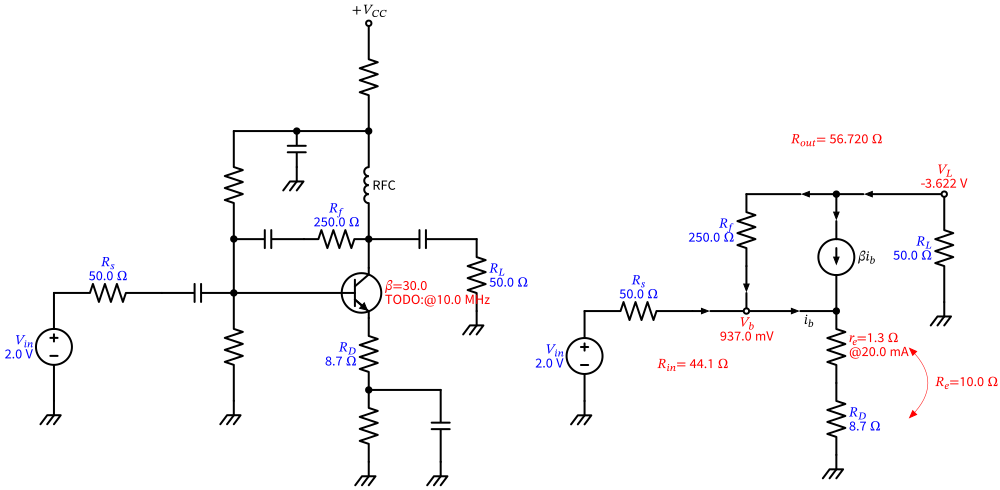

In [1]:
import math

import ipywidgets as widgets
import numpy as np
import pint
import plotly.graph_objects as go
import plotly.io as pio
import schemdraw as schem
import schemdraw.elements as e
from eseries import E12, E24, E48, erange, find_nearest
from ipywidgets import Layout, interact, interact_manual
from schemdraw import dsp  # , flow

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Support rendering plots in github
pio.renderers.default = "jupyterlab+png"
schem.use("svg")

ureg = pint.UnitRegistry()
layout = Layout(width="auto")
style = {"description_width": "50px"}

###############################################################


def beta_at_F(F=10 * 10**6, FT=300 * 10**6, B0=100):
    """Calc Beta at given frequency (from Hybrid-pi model)"""
    return B0 / (1 + (1j * B0 * (F / FT)))


def draw_fba(
    Rs=50.0,
    RL=50.0,
    Rf=250.0,
    RD=8.7,
    Ie=20 * 10**-3,
    B0=30,
    FT=300 * 10**6,
    F=10 * 10**6,
    Vin=2,
):
    re = 26 / (Ie * 10**3)
    Re = RD + re
    # Beta = abs(beta_at_F(F=F, FT=FT, B0=B0))
    Beta = B0

    A = 1 / (Re * (Beta + 1)) + 1 / Rf + 1 / Rs
    B = 1 / Rf
    C = Beta / (Re * (Beta + 1)) - 1 / Rf
    D = 1 / Rf + 1 / RL
    D2 = 1 / Rf + 1 / (2 * RL)

    Vb = (Vin * D / Rs) / (B * C + A * D)
    Vb2 = (Vin * D2 / Rs) / (B * C + A * D2)

    VL = -Vb * C / D
    VL2 = -Vb2 * C / D2

    Rin = Rs / (Vin / Vb - 1)
    Rout = (2 * RL * (VL2 - VL)) / (2 * VL - VL2)

    # Av = VL / Vin

    # Zs = Rs
    # ZL = RL

    # Zi = (Zs * Av) / Av
    # Zo = Av / (Av / ZL)

    d = schem.Drawing()

    d += e.GroundChassis()
    d += (
        e.SourceV()
        .up()
        .length(3)
        .label("$V_{in}$" + f"\n{(Vin*ureg.volt):.1f~#P}", color="blue")
    )
    d += (
        e.Resistor()
        .label("$R_s$" + f"\n{(Rs*ureg.ohm):.1f~#P}", color="blue")
        .right()
        .length(3)
    )
    d += e.Capacitor().length(2)
    d += e.Dot()
    d.push()
    d += e.Resistor().down()
    d += e.GroundChassis()
    d.pop()
    d.push()
    d += e.Line().length(1.5).up()
    d += e.Dot()
    d += e.Resistor().up()
    d += e.Line().right().length(1.75)
    d += e.Dot()
    d.push()
    d += e.Capacitor().down().length(1)
    d += e.GroundChassis()
    d.pop()
    d += e.Line().length(2)
    d += e.Dot()

    d.pop()
    d += e.Line().right()
    d += (
        TR1 := e.BjtNpn(circle=True).label(
            f"$\\beta$={Beta:.1f}\nTODO:@{(F*ureg.hertz):.1f~#P}", color="red"
        )
    )

    d += e.Line().up().at(TR1.collector).length(0.8)
    d += e.Dot()
    d.push()
    d += (
        e.Resistor()
        .label("$R_f$" + f"\n{(Rf*ureg.ohm):.1f~#P}", color="blue")
        .left()
        .length(1.8)
    )
    d += e.Capacitor().length(2)
    d.pop()
    d.push()
    d += e.Inductor().label("RFC", loc="bot").up()
    d += e.Resistor().length(3)
    d += e.Dot(open=True).label("$+V_{CC}$")

    d.pop()
    d += e.Capacitor().right()
    d += (
        eRL := e.Resistor()
        .down()
        .label("$R_L$" + f"\n{(RL*ureg.ohm):.1f~#P}", color="blue", loc="bot")
        .length(2)
    )
    d += e.GroundChassis()

    d += (
        e.Resistor()
        .label("$R_D$" + f"\n{(RD*ureg.ohm):.1f~#P}", color="blue")
        .down()
        .at(TR1.emitter)
        .length(2)
    )
    d += e.Dot()
    d.push()
    d += e.Resistor().down().length(2)
    d += e.GroundChassis()
    d.pop()
    d += e.Line().right().length(2)
    d += e.Capacitor().down().length(2)
    d += e.GroundChassis()

    ########################
    # small-signal equiv:-
    d += e.Gap().at(eRL.end).right()
    d.push()
    d += (
        e.SourceV()
        .label("$V_{in}$" + f"\n{(Vin*ureg.volt):.1f~#P}", color="blue")
        .down()
        .reverse()
        .length(2.5)
    )
    d += e.GroundChassis()
    d.pop()
    d += (
        e.Resistor()
        .label("$R_s$" + f"\n{(Rs*ureg.ohm):.1f~#P}", color="blue")
        .right()
        .length(3)
    )
    d.push()

    d += (
        e.Gap()
        .down()
        .label(
            "$R_{in}$" + f"= {(Rin*ureg.ohm):.3~#P}",
            # + "\n$Z_i$"
            # + f"= {(Zi*ureg.ohm):.3~#P}",
            color="red",
        )
    )

    d.pop()
    d += e.Arrow().length(0.5)
    d += e.Line().length(1)
    d += e.Dot(open=True).label(
        "$V_b$" + f"\n{(Vb*ureg.volt):.1f~#P}", color="red", loc="bot"
    )
    d += e.Arrow().label("$i_b$", loc="end").length(1.5)
    d += e.Line().length(1)
    d += e.Dot()
    d.push()

    d += (
        re := e.Resistor()
        .label(
            "$r_e$" + f"={(re*ureg.ohm):.1f~#P}\n@{(Ie *ureg.ampere):.1f~#P}",
            color="red",
            loc="bot",
        )
        .down()
        .length(2)
    )
    d += (
        RD := e.Resistor()
        .label("$R_D$" + f"\n{(RD*ureg.ohm):.1f~#P}", color="blue", loc="bot")
        .down()
        .length(2)
    )
    d += e.GroundChassis()

    d += (
        e.Arc2(arrow="<->", radius=0.6, color="red")
        .linewidth(0.5)
        .at(re.center, dx=2.0, dy=0)
        .to(RD.center, dx=2.0, dy=0)
        .label("$R_e$" + f"={(Re*ureg.ohm):.1f~#P}", color="red", ofst=(0.25, 0))
    )

    d.pop()
    d += e.Line().up().length(1)
    d += e.SourceI().reverse().up().label("$\\beta i_b$", loc="bot").length(1)
    d += e.Line().length(0.5)
    d += e.Arrow().reverse().length(0.75)
    d += e.Dot()
    d.push()

    d += (
        e.Gap()
        .up()
        .label(
            "$R_{out}$" + f"= {(Rout*ureg.ohm):.3f~#P}",
            # + "\n$Z_o$"
            # + f"= {(Zo*ureg.ohm):.3f~#P}"
            # + "\n$A_v$"
            # + f"= {(Av):.3f}",
            color="red",
        )
    )

    d.pop()
    d.push()
    d += e.Arrow().left().length(1)
    d += e.Line().length(1.5)
    d += (
        e.Resistor()
        .label("$R_f$" + f"\n{(Rf*ureg.ohm):.1f~#P}", color="blue")
        .down()
        .length(2)
    )
    d += e.Arrow().length(0.75)
    d += e.Line().length(0.5)

    d.pop()
    d += e.Line().length(0.75).right()
    d += e.Arrow().reverse().length(2.25)
    d += e.Dot(open=True).label("$V_L$" + f"\n{(VL*ureg.volt):.3f~#P}", color="red")
    d += e.Resistor().label("$R_L$" + f"\n{(RL*ureg.ohm):.1f~#P}", color="blue").down()
    d += e.GroundChassis()

    return d


draw_fba().draw()

In [48]:
import math
import sys

import ipywidgets as widgets

# import numpy as np
import pint

# import plotly.graph_objects as go
import plotly.io as pio
import schemdraw as schem
import schemdraw.elements as e
from eseries import E12, E24, E48, E96, erange
from IPython.display import display
from ipywidgets import Layout, interactive
from ycx_complex_numbers import Complex, NetABCD, NetY, NetZ, Y, Z

%matplotlib inline
%config InlineBackend.figure_format = 'svg'


# Support rendering plots in github
pio.renderers.default = "jupyterlab+png"
schem.use("svg")

ureg = pint.UnitRegistry()
layout = Layout(width="auto")
style = {"description_width": "200px"}

###############################################################


def hybrid_pi(
    F_mhz=10,
    FT_mhz=300,
    B0=100,
    Ie_mA=10,
    Rbp=10.0,
    Re=6.8,
    Le_nH=0,
    Ccb_pF=5,
    Cf_pF=10000,
    Lf_nH=20,
    Rf=1000,
    ZS=50,
    ZL=50,
):
    Ccb = Ccb_pF * 10**-12
    Le = Le_nH * 10**-9
    F = F_mhz * 10**6
    FT = FT_mhz * 10**6
    Ie = Ie_mA * 10**-3

    Cf = Cf_pF * 10**-12
    Lf = Lf_nH * 10**-9

    ZS = ZS + 0j
    ZL = ZL + 0j

    beta = B0 / (1 + (1j * B0 * F) / FT)

    jw = 1j * 2 * math.pi * F

    # base spreading resistor as ABCD matrix for cascading below
    Rbp_A = NetABCD(A=1, B=Rbp, C=0, D=1)

    re = 26 / Ie_mA
    Ze = Z(re + Re + (jw * Le))

    # feedback network as an admittance for later adding in parallel
    Zf = Z(Rf + 1j * (2 * math.pi * F * Lf - 2 * math.pi * F * Cf))
    Yf = NetY(y11=1 / Zf, y12=-1 / Zf, y21=-1 / Zf, y22=1 / Zf)

    y11e = Y(1 / (Ze * (beta + 1)) + (jw * Ccb))
    y12e = Y(0 - (jw * Ccb))
    y21e = Y(beta / (Ze * (beta + 1)) - (jw * Ccb))
    y22e = Y(0 + (jw * Ccb))
    Ye = NetY(y11=y11e, y12=y12e, y21=y21e, y22=y22e)

    # Cascade the base spreading resistance to the hybrid-pi amplifier
    Ae = Ye.to_ABCD()
    A1 = Rbp_A * Ae

    # Add feedback in parallel
    Y1 = A1.to_Y() + Yf

    yio = Y1.in_out(ys=1 / ZS, yl=1 / ZL)
    zin = Z(1 / yio["Yin"])
    zout = Z(1 / yio["Yout"])

    d = schem.Drawing()
    d += (
        e.Gap()
        .length(2)
        .up()
        .label("${Z_{in}$" + f"\n{zin:.2f}", loc="left", color="red")
    )
    d += e.Gap().length(2).right()
    d += e.Dot(open=True).label("b", loc="left")
    d += e.Line().right().length(2)
    d += (
        e.Resistor().right().label(f"$R^`_b$\n{(Rbp * ureg.ohms):.1f~#P}", color="blue")
    )
    d += e.Line().right().length(1.5)
    d += e.Dot().label(f"$I_e$={(Ie * ureg.ampere):.1f~#P}", color="blue", loc="right")
    d.push()
    d += (
        e.Resistor()
        .label("$r_e$" + f"={(re * ureg.ohms):.1f~#P}", color="red", loc="bot")
        .down()
        .length(2)
    )
    d += e.Dot().label("e", loc="right")
    d.push()
    d += e.Gap().length(6).right().label(f"$Z_e$={(Ze.c * ureg.ohms):.2}", color="red")
    d.pop()
    d += (
        e.Resistor()
        .label("$R_e$" + f"\n{(Re * ureg.ohms):.1f~#P}", color="blue", loc="bot")
        .length(2)
    )
    d += (
        e.Inductor()
        .label("$L_e$" + f"\n{(Le * ureg.henrys):.1f~#P}", color="blue", loc="bot")
        .length(2)
    )
    d += e.GroundChassis()

    d.pop()
    d += (
        e.SourceI()
        .length(2)
        .reverse()
        .label(
            "$\\beta i_b$" + f"\n$|\\beta|$={abs(beta):.1f}@{(F*ureg.hertz):.1f~#P}",
            color="red",
            loc="bot",
        )
    )
    d += e.Dot()
    d.push()
    d += e.Line(ls="dashed").left().length(1)
    d += (
        e.Capacitor(ls="dashed")
        .length(2)
        .label("$C_{cb}$" + f"\n{(Ccb * ureg.farads):.1f~#P}", color="blue")
        .down()
    )
    d += e.Dot()

    d.pop()
    d += e.Line().up().length(1)
    d += e.Dot()
    d.push()

    # feedback
    d += (
        e.Capacitor()
        .label(f"$C_f$\n{(Cf * ureg.farads):.1f~#P}", color="blue")
        .left()
        .length(2)
    )
    d += (
        e.Inductor()
        .label("$L_f$" + f"\n{(Lf * ureg.henrys):.1f~#P}", color="blue")
        .flip()
        .length(2)
    )
    d += e.Line().length(1)
    d += (
        e.Resistor()
        .label("$R_f$" + f"\n{(Rf * ureg.ohms):.1f~#P}", color="blue")
        .down()
        .length(3)
    )
    d += e.Dot()

    d.pop()
    d += e.Line().right()
    d += e.Dot(open=True).label("c", loc="right")
    d += e.Gap().right().length(7)
    d += (
        e.Gap()
        .down()
        .length(4)
        .label(
            # f"Ye\n{Ye}\nYin\n{yio['Yin']}\nYout\n{yio['Yout']}\n- - -\n"
            "${Z_{out}$" + f"\n{zout:.2f}",
            loc="left",
            color="red",
        )
    )

    display(d)
    return d


res_series = E24
interactive_hybrid_pi = interactive(
    hybrid_pi,
    F_mhz=widgets.FloatText(
        value=10.0,
        description="$F$ MHz",
        style=style,
        # layout=layout,
    ),
    FT_mhz=widgets.FloatText(
        value=300.0,
        description="$F_T$ MHz",
        style=style,
        # layout=layout,
    ),
    B0=widgets.FloatText(
        value=100.0,
        description="$B0$",
        style=style,
        # layout=layout,
    ),
    Ie_mA=widgets.FloatText(
        value=10.0,
        description="$I_e$ mA",
        style=style,
        # layout=layout,
    ),
    Rbp=widgets.FloatText(
        value=10.0,
        description="$R^`_b$ base spreading resistance",
        style=style,
        # layout=layout,
    ),
    Re=widgets.SelectionSlider(
        value=6.8,
        description="$R_e$",
        options=[
            0.0,
        ]
        + list(erange(res_series, 1, 1000.0)),
        style=style,
        layout=layout,
    ),
    Le_nH=widgets.FloatText(
        value=10.0,
        description="$Le$ nH",
        style=style,
        # layout=layout,
    ),
    Ccb_pF=widgets.FloatText(
        value=5.0,
        description="$C_{cb}$ pF",
        style=style,
        # layout=layout,
    ),
    Cf_pF=widgets.SelectionSlider(
        value=10000.0,
        description="$C_f$ pF",
        options=list(erange(res_series, 1, 10000.0)),
        style=style,
        layout=layout,
    ),
    Lf_nH=widgets.FloatText(
        value=20.0,
        description="$Lf$ nH",
        style=style,
        # layout=layout,
    ),
    Rf=widgets.SelectionSlider(
        value=1000,
        description="$R_f$",
        options=list(erange(res_series, 1, 100000.0)),
        style=style,
        layout=layout,
    ),
    ZS=widgets.SelectionSlider(
        value=50,
        description="$Z_S$",
        options=[25, 50, 100, 150, 200, 250, 300, 400, 500, 1000, 5000, 10000],
        style=style,
        layout=layout,
    ),
    ZL=widgets.SelectionSlider(
        value=50,
        description="$Z_L$",
        options=[25, 50, 100, 150, 200, 250, 300, 400, 500, 1000, 5000, 10000],
        style=style,
        layout=layout,
    ),
)

display(interactive_hybrid_pi)

interactive(children=(FloatText(value=10.0, description='$F$ MHz', style=DescriptionStyle(description_width='2…